In [2]:
import warnings
import random 
import os
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests

class DataLoader: 

    ZCTA_geo_datapath = '../datasets/State-zip-code-GeoJSON/*.json'
    claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv'
    zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv'
    irs_data_path='../datasets/Demographics/22irs.csv'
    zip_geos_pd='json_to_dfs_no_geom'

    FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
    FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'

    DUCKDB_location = '../datasets/combined_data.db'
    
    def __init__(self): 
        try:
            self.con = self.initialize_ddb()
        except Exception as e: 
            print(e) 
            pass 

    def retrieve_regional_data_snapshot(self, region_str):
        
        assert hasattr(self, 'con') 

        df = self.con.sql(f"select * from zillow_home_prices where Metro ilike '%{region_str}%'").df()
        cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3]
        zillow_df = df[cols]
        zillow_df = zillow_df.rename(
            columns={
                'RegionName':'zip'
            }
        )
        
        zip_codes = zillow_df['zip'].unique()

        zips_str = ','.join(zip_codes)
        irs_df = self.con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
        claims_df = self.con.sql(
            f'''
             select * 
             from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
             inner join zip_geos using (zip)
             order by dateOfLoss
             ;
             '''
        ).df()

        return {
            'ZILLOW' : zillow_df, 
            'IRS_SOCIO': irs_df, 
            'NFIP_CLAIMS': claims_df
        }

    def retrieve_macroeconomic_data(self):

        if hasattr(self, 'macro_data'):
            return self.macro_data 
            
        econ_dataset_codes = {
            'fed_funding_rate':'DFF', 
            '30yr_mortgage_avg':'MORTGAGE30US', 
            '15yr_mortgage_avg':'MORTGAGE15US',  
            'consumer_price_idx':'CPIAUCSL', 
            'real_disposable_income':'DSPIC96', 
            'real_disp_income_per_capita':'A229RX0'
        }

        data=[]
        for col, code in econ_dataset_codes.items(): 
            params = {
                'series_id': code, 'api_key': self.FRED_api_key, 'file_type': 'json'
            }
            try: 
                resp = requests.get(self.FRED_api_endpoint, params=params).json()
                resp_df = pd.DataFrame(resp['observations'])\
                    .drop(columns=['realtime_start','realtime_end'])\
                    .rename(columns={'value':col})
                resp_df[col] = resp_df[col].astype(float)
                resp_df['date'] = pd.to_datetime(resp_df['date'])
                resp_df['year'] = resp_df['date'].dt.year
                resp_df['month'] = resp_df['date'].dt.month 
                resp_df_monthly = resp_df\
                    .drop(columns=['date'])\
                    .groupby(['year','month'])[[col]].mean()
            
                data.append(resp_df_monthly)
            except Exception as e: 
                print(e)
                continue
                        
        cct = pd.concat(data,axis=1)\
            .sort_values(by=['year','month'])\
            .reset_index()
        cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
        cct['date'] = pd.to_datetime(cct['date']) 
        cct = cct.set_index('date')
        self.macro_data = cct
        return cct
        
    def initialize_ddb(self):
        
        if os.path.exists(self.DUCKDB_location): 
            return duckdb.connect(self.DUCKDB_location)
            
        base_query = '''
        drop table if exists nfip_claims
        ;

        create table nfip_claims as 
        select  
            id,
            asOfDate, 
            dateOfLoss,
            policyCount as insuredUnits, 
            baseFloodElevation, 
            ratedFloodZone, 
            occupancyType, 
            originalConstructionDate, 
            originalNBDate, 
            coalesce(amountPaidOnBuildingClaim,0) +                  
            coalesce(amountPaidOnContentsClaim,0) +                  
            coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
            coalesce(totalBuildingInsuranceCoverage,0) + 
            coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
            coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
            buildingDeductibleCode, 
            contentsDeductibleCode,
            causeOfDamage, 
            buildingPropertyValue, 
            floodproofedIndicator, 
            floodEvent, 
            state, 
            reportedZipCode, 
            censusTract, 
            latitude, 
            longitude
        from read_csv('{claims_data_path}', strict_mode=False)
        ;

        drop table if exists nfip_claims_zip 
        ; 

        create table nfip_claims_zip as 
        select 
            reportedZipCode as zip, 
            state,
            floodEvent,
            dateOfLoss,
            count(id) as claimCounts,
            sum(insuredUnits) as policyCounts, 
            sum(totalClaim) as totalClaimZip, 
            sum(totalDamageLoss) as totalLossesZip
        from nfip_claims
        where dateOfLoss >= '2000-01-01'
        group by 1,2,3,4
        order by 5 desc
        ;

        drop table if exists irs_zip
        ;

        create table irs_zip as 
        select 
            STATE, 
            ZIPCODE as zip, 
            AGI_STUB as adjGrossIncomeTaxBracket,
            N1 as numberTaxReturns, 
            MARS1 as singleStatusTotalReturns, 
            MARS2 as marriedStatusTotalReturns, 
            MARS4 as HoHTotalReturns, 
            N2 as totalIndividuals,
            VITA as volunteerAssistedReturns, 
            ELDERLY as elderlyReturns, 
            A00100 as adjustedGrossIncome, 
            A02650 as totalIncome, 
            N00200 as returnsTotalwSalariesWages, 
            N00300 as returnsTotalTaxableInterest, 
            A00300 as taxableInterestAmt,
            SCHF   as returnsTotalFarm, 
            A18450 as stateLocalSalesTaxTotal, 
            N18500 as realEstateTaxTotal, 
            N18800 as returnsTotalPersonalPropertyTax, 
            A18800 as propertyTaxAmtTotal, 
            N19300 as returnsTotalMortgageInterestPaid, 
            A19300 as mortgageInterestPaidTotal,
            N07225 as returnsDependentCareCredit, 
            A07225 as dependentCareCreditTotal, 
            N07230 as returnsEducationCredit, 
            A07230 as educationCreditTotal, 
            N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
            A85770 as premiumsCreditTotal, 
        from read_csv('{irs_data_path}', strict_mode=False)
        ;
    
        drop table if exists zillow_home_prices
        ;

        create table zillow_home_prices as 
        select * 
        from read_csv('{zillow_data_path}', strict_mode=False)
        ;

        drop table if exists zip_geos
        ;

        create table zip_geos as 
        select * 
        from {zip_geos_pd}
        ;
        '''

        read_jsons = [
            gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] 
            for gj in glob.glob(self.ZCTA_geo_datapath)
        ]
        json_to_dfs = pd.concat(read_jsons)
        json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
                }
            )
        json_to_dfs_no_geom = json_to_dfs.drop(columns=['geometry'])
        con = duckdb.connect(self.DUCKDB_location)
        con.sql(
            base_query.format(
                claims_data_path=self.claims_data_path,
                zillow_data_path=self.zillow_data_path, 
                irs_data_path=self.irs_data_path, 
                zip_geos_pd=self.zip_geos_pd
            )
        )
        return con

#### Analyze Realtor.com dataset

In [3]:
import pandas as pd 
import numpy as np 
dl = DataLoader() 
dl.initialize_ddb() 
dl.con.close()

path = '../datasets/Zillow-home-prices/RDC_Inventory_Core_Metrics_Zip_History.csv'
df = pd.read_csv(path).dropna()
print(len(df))
df.head(10)
df['state'] = df['zip_name'].str.split(', ').apply(lambda x: x[1])
df['year'] = df['month_date_yyyymm'].astype(str).apply(lambda x: x[:4])
df['month'] = df['month_date_yyyymm'].astype(str).apply(lambda x: x[4:])
df['postal_code'] = df['postal_code'].astype(str).apply(lambda x: x.rjust(5,'0'))
df.columns

cols = [
    'state',
    'year', 
    'month', 
    'postal_code', 
    'active_listing_count', 
    'median_days_on_market', 
    'new_listing_count', 
    'pending_listing_count',  
    'median_square_feet', 
    'quality_flag'
]

df_trunc = df[cols].sort_values(by=['year','month'])
df_trunc


159341


,state,year,month,postal_code,active_listing_count,median_days_on_market,new_listing_count,pending_listing_count,median_square_feet,quality_flag
2565143,az,2017,07,85042,113.0,44.0,68.0,33.0,2156.0,0.0
2565146,tx,2017,07,78154,141.0,43.0,68.0,113.0,2506.0,0.0
2565152,ca,2017,07,95838,71.0,32.0,60.0,92.0,1318.0,0.0
2565169,sc,2017,07,29569,113.0,86.0,24.0,51.0,1601.0,0.0
2565194,ny,2017,07,11706,194.0,64.0,56.0,54.0,1926.0,0.0
...,...,...,...,...,...,...,...,...,...,...
27581,tx,2025,02,79938,450.0,56.0,226.0,257.0,1857.0,1.0
27593,tx,2025,02,76065,207.0,66.0,72.0,120.0,2874.0,0.0
27683,tn,2025,02,37363,203.0,79.0,86.0,135.0,2599.0,0.0
27701,al,2025,02,35040,127.0,63.0,46.0,62.0,1510.0,0.0


In [19]:
df_trunc = df_trunc.loc[df_trunc['state']=='fl']
df_trunc

,state,year,month,postal_code,active_listing_count,median_days_on_market,new_listing_count,pending_listing_count,median_square_feet,quality_flag
2565195,fl,2017,07,33813,206.0,58.0,88.0,92.0,2544.0,0.0
2565324,fl,2017,07,34134,437.0,117.0,48.0,83.0,1973.0,0.0
2565473,fl,2017,07,34219,183.0,58.0,52.0,79.0,2435.0,0.0
2565633,fl,2017,07,33584,67.0,47.0,56.0,84.0,1904.0,1.0
2565674,fl,2017,07,32828,189.0,44.0,148.0,164.0,2441.0,0.0
...,...,...,...,...,...,...,...,...,...,...
27027,fl,2025,02,33009,1120.0,86.0,224.0,97.0,1075.0,0.0
27179,fl,2025,02,34759,527.0,86.0,140.0,116.0,1687.0,0.0
27218,fl,2025,02,33881,238.0,85.0,64.0,55.0,1723.0,0.0
27376,fl,2025,02,32738,205.0,59.0,86.0,75.0,1646.0,0.0


In [17]:
state = ', FL'
home_pr_index, irs, claims = dl.retrieve_regional_data_snapshot(state).values()

In [20]:
df_trunc

,state,year,month,postal_code,active_listing_count,median_days_on_market,new_listing_count,pending_listing_count,median_square_feet,quality_flag
2565195,fl,2017,07,33813,206.0,58.0,88.0,92.0,2544.0,0.0
2565324,fl,2017,07,34134,437.0,117.0,48.0,83.0,1973.0,0.0
2565473,fl,2017,07,34219,183.0,58.0,52.0,79.0,2435.0,0.0
2565633,fl,2017,07,33584,67.0,47.0,56.0,84.0,1904.0,1.0
2565674,fl,2017,07,32828,189.0,44.0,148.0,164.0,2441.0,0.0
...,...,...,...,...,...,...,...,...,...,...
27027,fl,2025,02,33009,1120.0,86.0,224.0,97.0,1075.0,0.0
27179,fl,2025,02,34759,527.0,86.0,140.0,116.0,1687.0,0.0
27218,fl,2025,02,33881,238.0,85.0,64.0,55.0,1723.0,0.0
27376,fl,2025,02,32738,205.0,59.0,86.0,75.0,1646.0,0.0


In [163]:
home_pr_rs = home_pr_index.set_index('zip').drop(columns=['Metro', 'CountyName']).T.rename_axis('date')
home_pr_roc = home_pr_rs.diff().div(home_pr_rs)
home_pr_roc = home_pr_roc.reset_index()
home_pr_roc['year'] = home_pr_roc['date'].str.split('-').apply(lambda x: x[0])
home_pr_roc['month'] = home_pr_roc['date'].str.split('-').apply(lambda x: x[1])

home_pr_roc = home_pr_roc.drop(columns=['date'])
home_pr_melted = pd.melt(home_pr_roc, id_vars=['year','month'],var_name='postal_code', value_name='price_change')

combined_home_attr = \
home_pr_melted.merge(
    df_trunc, 
    how='left', 
    on=[
        'year', 
        'month', 
        'postal_code'
    ]
)

combined_home_attr = combined_home_attr\
    .set_index(['year','month','postal_code'])\
    .drop(columns=['state'])

combined_home_attr.head(10)



price_change  active_listing_count  \
year month postal_code                                       
2000 01    34787                 NaN                   NaN   
     02    34787            0.005663                   NaN   
     03    34787            0.004631                   NaN   
     04    34787            0.008135                   NaN   
     05    34787            0.005553                   NaN   
     06    34787            0.002897                   NaN   
     07    34787            0.002388                   NaN   
     08    34787            0.003485                   NaN   
     09    34787            0.007322                   NaN   
     10    34787            0.008683                   NaN   

                        median_days_on_market  new_listing_count  \
year month postal_code                                             
2000 01    34787                          NaN                NaN   
     02    34787                          NaN                NaN   
     03    34787                          NaN                NaN   
     04    34787                          NaN                NaN   
     05    34787                          NaN                NaN   
     06    34787                          NaN                NaN   
     07    34787                          NaN                NaN   
     08    34787                          NaN                NaN   
     09    34787                          NaN                NaN   
     10    34787                          NaN                NaN   

                        pending_listing_count  median_square_feet  \
year month postal_code                                              
2000 01    34787                          NaN                 NaN   
     02    34787                          NaN                 NaN   
     03    34787                          NaN                 NaN   
     04    34787                          NaN                 NaN   
     05    34787                          NaN                 NaN   
     06    34787                          NaN                 NaN   
     07    34787                          NaN                 NaN   
     08    34787                          NaN                 NaN   
     09    34787                          NaN                 NaN   
     10    34787                          NaN                 NaN   

                        quality_flag  
year month postal_code                
2000 01    34787                 NaN  
     02    34787                 NaN  
     03    34787                 NaN  
     04    34787                 NaN  
     05    34787                 NaN  
     06    34787                 NaN  
     07    34787                 NaN  
     08    34787                 NaN  
     09    34787                 NaN  
     10    34787                 NaN

In [164]:
combined_home_attr.corr()['price_change']

price_change             1.000000
active_listing_count    -0.364010
median_days_on_market   -0.505664
new_listing_count       -0.038140
pending_listing_count    0.143647
median_square_feet      -0.041872
quality_flag             0.111178
Name: price_change, dtype: float64

In [165]:
df_trunc.drop(columns=['state']).pivot(
    columns='postal_code', 
    values='active_listing_count', 
    index=['year','month']
)

postal_code  32003  32011  32024  32025  32034  32043  32046  32063  32065  \
year month                                                                   
2017 07      160.0    NaN    NaN    NaN  471.0  150.0    NaN    NaN  140.0   
     08        NaN    NaN    NaN    NaN  461.0  152.0    NaN    NaN  141.0   
     09      150.0    NaN    NaN    NaN  450.0  151.0    NaN    NaN  143.0   
     10        NaN    NaN    NaN    NaN  446.0    NaN    NaN    NaN  131.0   
     11      126.0    NaN    NaN    NaN  461.0    NaN    NaN    NaN    NaN   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
2024 10        NaN    NaN    NaN    NaN    NaN  265.0    NaN    NaN    NaN   
     11        NaN    NaN    NaN    NaN  452.0  265.0    NaN    NaN  183.0   
     12        NaN    NaN    NaN    NaN    NaN  277.0    NaN    NaN    NaN   
2025 01        NaN    NaN    NaN    NaN    NaN  267.0   53.0    NaN    NaN   
     02        NaN    NaN    NaN    NaN  486.0  252.0   55.0    NaN  155.0   

postal_code  32068  ...  34974  34982  34983  34984  34986  34987  34990  \
year month          ...                                                    
2017 07      165.0  ...  122.0   94.0  203.0  100.0  287.0    NaN  370.0   
     08      131.0  ...    NaN    NaN  184.0   93.0    NaN    NaN  346.0   
     09      129.0  ...    NaN   77.0  184.0   89.0    NaN  132.0  343.0   
     10      122.0  ...    NaN    NaN  181.0   92.0  294.0  120.0  335.0   
     11      136.0  ...    NaN   95.0  174.0   97.0  292.0  116.0  353.0   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
2024 10        NaN  ...    NaN    NaN  219.0    NaN  355.0  330.0    NaN   
     11        NaN  ...    NaN    NaN    NaN    NaN  347.0  346.0    NaN   
     12        NaN  ...    NaN  173.0    NaN    NaN  340.0  359.0    NaN   
2025 01        NaN  ...    NaN  174.0  241.0    NaN  368.0  405.0    NaN   
     02        NaN  ...    NaN  184.0  280.0    NaN  432.0  450.0    NaN   

postal_code  34994  34996  34997  
year month                        
2017 07        NaN    NaN  286.0  
     08      142.0  175.0  272.0  
     09        NaN    NaN  269.0  
     10        NaN    NaN  261.0  
     11      150.0    NaN  262.0  
...            ...    ...    ...  
2024 10        NaN    NaN  282.0  
     11        NaN    NaN  291.0  
     12        NaN    NaN    NaN  
2025 01        NaN    NaN  330.0  
     02        NaN    NaN  356.0  

[92 rows x 740 columns]

In [166]:
combined_home_attr_trunc = combined_home_attr[['price_change', 'active_listing_count', 'median_days_on_market']].reset_index()
combined_home_attr_trunc

,year,month,postal_code,price_change,active_listing_count,median_days_on_market
0,2000,01,34787,NaN,NaN,NaN
1,2000,02,34787,0.005663,NaN,NaN
2,2000,03,34787,0.004631,NaN,NaN
3,2000,04,34787,0.008135,NaN,NaN
4,2000,05,34787,0.005553,NaN,NaN
...,...,...,...,...,...,...
264295,2024,08,32664,-0.000763,NaN,NaN
264296,2024,09,32664,0.000772,NaN,NaN
264297,2024,10,32664,0.000633,NaN,NaN
264298,2024,11,32664,-0.001757,NaN,NaN


In [167]:
risk_variables = claims.copy() 
risk_variables['year'] = risk_variables['dateOfLoss'].dt.year 
risk_variables['month'] = risk_variables['dateOfLoss'].dt.month 
risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])
zip_ = \
    risk_variables.groupby([
        'zip', 
        'year', 
        'floodEvent', 
    ]).agg(
                totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
                totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
                waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
        )

zip_['log(totalClaims)'] = np.log(zip_['totalClaims']+0.000001) 
zip_['log(totalLosses)'] = np.log(zip_['totalLosses']+0.000001) 

disaster_claims = zip_.reset_index() 
disaster_claims = disaster_claims.rename(
    columns={
        'zip':'postal_code'
    }
)

disaster_claims.head(10)

/opt/anaconda3/envs/cusp_python_3_9/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,postal_code,year,floodEvent,totalClaims,totalLosses,waterAreaProp,log(totalClaims),log(totalLosses)
0,32003,2001,Torrential rain,41308.51,44809.0,0.307561,10.628824,10.710164
1,32003,2004,Hurricane Frances,63150.37,77152.0,0.307561,11.053274,11.253533
2,32003,2004,Hurricane Ivan,32221.37,33222.0,0.307561,10.380385,10.410968
3,32003,2004,Hurricane Jeanne,525368.36,561973.0,0.307561,13.171855,13.239209
4,32003,2008,Tropical Storm Fay,121993.27,129386.0,0.307561,11.711721,11.770555
5,32003,2012,Tropical Storm Debby,17444.89,17795.0,0.307561,9.766802,9.786673
6,32003,2016,Hurricane Matthew,64644.57,65639.0,0.307561,11.076659,11.091925
7,32003,2017,Hurricane Irma,14981592.48,14934098.0,0.307561,16.522333,16.519158
8,32003,2022,Hurricane Ian,70427.77,62398.0,0.307561,11.162343,11.041289
9,32003,2022,Hurricane Nicole,633628.38,446395.0,0.307561,13.359218,13.008959


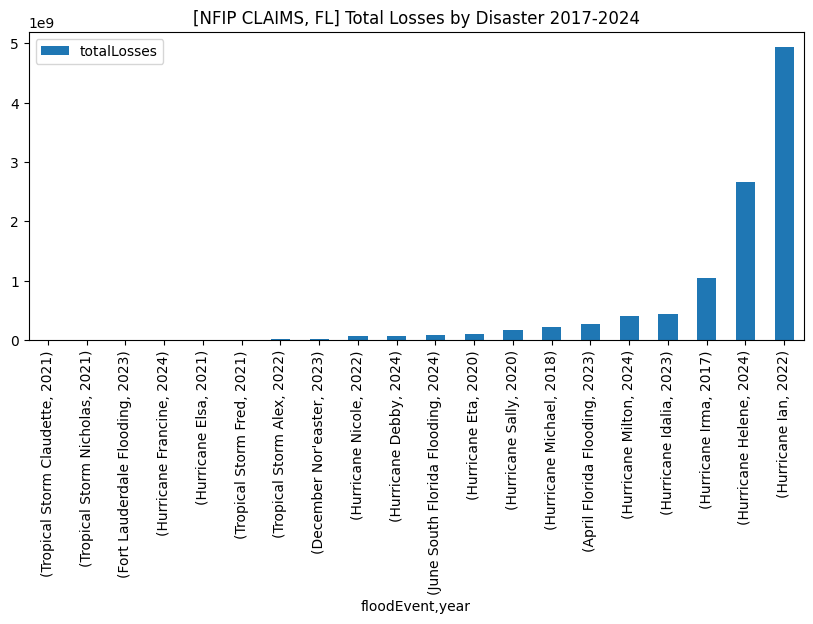

In [168]:
disaster_claims\
    .loc[disaster_claims['year']>=2017]\
    .groupby(['floodEvent','year'])[['totalLosses']]\
    .sum()\
    .sort_values(by=['totalLosses'])\
    .plot(
        kind='bar', 
        figsize=(10,4), 
        title='[NFIP CLAIMS, FL] Total Losses by Disaster 2017-2024'

    )

plt.show()

In [169]:
##### choose Hurricane Ian, w the most losses.... 
##### note, hazard data isn't temporal in nature...it should only be used to assign zip-code treatment risk groups...

claims_ian = disaster_claims\
    .loc[disaster_claims['floodEvent']=='Hurricane Helene']\
    .drop(
        columns=[
            'floodEvent', 'year'
        ]
    )

loglosses_ian = claims_ian.set_index('postal_code')[[
    'log(totalClaims)'
]]

loglosses_ian.sort_values(by=['log(totalClaims)']).head(25)
nolosses = loglosses_ian.min().iloc[0]
loglosses_ian['grp_assignment'] = loglosses_ian['log(totalClaims)'] > nolosses

loglosses_ian


,log(totalClaims),grp_assignment
postal_code,,
32003,11.162343,True
32034,11.244886,True
32043,10.728164,True
32068,11.549209,True
32080,16.669404,True
...,...,...
34972,-13.815511,False
34974,-13.815511,False
34986,10.484170,True


In [195]:
combined = combined_home_attr_trunc.merge(loglosses_ian.reset_index(), how='left', on='postal_code')
combined = combined.loc[combined['year'].astype(int).between(2023,2025)]
combined.head(100)

combined.loc[combined['postal_code']=='33025']

,year,month,postal_code,price_change,active_listing_count,median_days_on_market,log(totalClaims),grp_assignment
1476,2023,01,33025,0.006852,NaN,NaN,NaN,NaN
1477,2023,02,33025,0.004711,NaN,NaN,NaN,NaN
1478,2023,03,33025,0.003835,NaN,NaN,NaN,NaN
1479,2023,04,33025,0.004354,67.0,40.0,NaN,NaN
1480,2023,05,33025,0.006553,NaN,NaN,NaN,NaN
1481,2023,06,33025,0.008926,NaN,NaN,NaN,NaN
1482,2023,07,33025,0.009121,71.0,35.0,NaN,NaN
1483,2023,08,33025,0.008520,NaN,NaN,NaN,NaN
1484,2023,09,33025,0.006311,75.0,38.0,NaN,NaN
1485,2023,10,33025,0.005313,NaN,NaN,NaN,NaN


In [198]:
np.count_nonzero(combined['active_listing_count'].isna())/len(combined)

0.7650397275822929

<Axes: xlabel='year,month'>

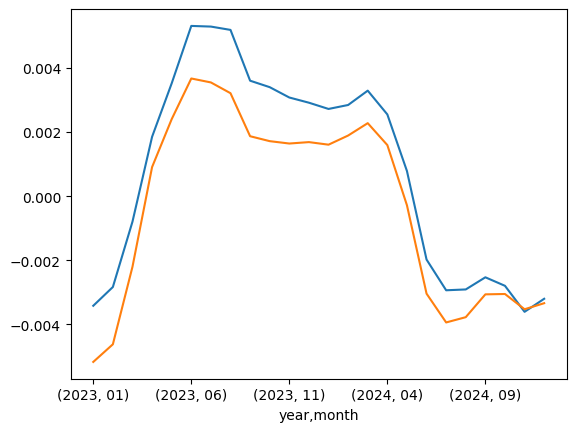

In [188]:
only_price_changes = combined[['year','month','postal_code','price_change','grp_assignment']].dropna()

noclaims_zip = only_price_changes.loc[only_price_changes['grp_assignment']==False]\
    .pivot(
        index=['year','month'],columns='postal_code',values='price_change'
    )\
.ffill()
claims_zip = only_price_changes.loc[only_price_changes['grp_assignment']==True]\
    .pivot(
        index=['year','month'],columns='postal_code',values='price_change'
    )\
.ffill()

#claims_zip.plot(color='grey',legend=False)
#plt.axvline('')

noclaims_zip.mean(axis=1).plot()
claims_zip.mean(axis=1).plot()



In [175]:
combined_home_attr_trunc.loc[combined_home_attr_trunc['postal_code']=='32003']

,year,month,postal_code,price_change,active_listing_count,median_days_on_market
83700,2000,01,32003,NaN,NaN,NaN
83701,2000,02,32003,0.001363,NaN,NaN
83702,2000,03,32003,0.003123,NaN,NaN
83703,2000,04,32003,0.005213,NaN,NaN
83704,2000,05,32003,0.007136,NaN,NaN
...,...,...,...,...,...,...
83995,2024,08,32003,-0.002998,NaN,NaN
83996,2024,09,32003,-0.001607,NaN,NaN
83997,2024,10,32003,-0.001234,NaN,NaN
83998,2024,11,32003,-0.001098,NaN,NaN


In [189]:
combined_home_attr_trunc

,year,month,postal_code,price_change,active_listing_count,median_days_on_market
0,2000,01,34787,NaN,NaN,NaN
1,2000,02,34787,0.005663,NaN,NaN
2,2000,03,34787,0.004631,NaN,NaN
3,2000,04,34787,0.008135,NaN,NaN
4,2000,05,34787,0.005553,NaN,NaN
...,...,...,...,...,...,...
264295,2024,08,32664,-0.000763,NaN,NaN
264296,2024,09,32664,0.000772,NaN,NaN
264297,2024,10,32664,0.000633,NaN,NaN
264298,2024,11,32664,-0.001757,NaN,NaN


In [17]:
df_trunc_ = df_trunc.loc[df_trunc['year'].astype(np.int32).between(2017,2020)]
df_trunc_.groupby(['year','postal_code'])[['active_listing_count','median_days_on_market']].mean().reset_index().sort_values(by=['postal_code'])
df_trunc_.loc[df_trunc_['state']=='tx'].sort_values(by=['postal_code']).pivot(columns='postal_code',values='active_listing_count',index=['year','month'])#.plot(legend=False)

postal_code  75001  75002  75006  75007  75009  75010  75013  75019  75020  \
year month                                                                   
2017 07        NaN  184.0   35.0   58.0  207.0  118.0  216.0  150.0  111.0   
     08        NaN  195.0   35.0   71.0  217.0  116.0  219.0  135.0  114.0   
     09        NaN  193.0   37.0   71.0  217.0  108.0  195.0  125.0  104.0   
     10        NaN  191.0   33.0   80.0  216.0   92.0  192.0  115.0   76.0   
     11        NaN  163.0   39.0   77.0  205.0   97.0  173.0  115.0   78.0   
     12        NaN  124.0   29.0   52.0  174.0   76.0  130.0   94.0  100.0   
2018 01       20.0  111.0   29.0   48.0  166.0   71.0  108.0   84.0    NaN   
     02        NaN  115.0   26.0   53.0  191.0   67.0  109.0   86.0   57.0   
     03        NaN  133.0   28.0   45.0  209.0   79.0  126.0   88.0   55.0   
     04        NaN  162.0   34.0   59.0  242.0   87.0  142.0  128.0   66.0   
     05       24.0  214.0   36.0   72.0  259.0  111.0  204.0  135.0   81.0   
     06        NaN  245.0   43.0   84.0  280.0  115.0  222.0  152.0   92.0   
     07        NaN  280.0    NaN   87.0  288.0  130.0    NaN    NaN    NaN   
     08        NaN  303.0    NaN   93.0  295.0  127.0  257.0  173.0   99.0   
     09        NaN  279.0   50.0   91.0  293.0  115.0  263.0  163.0  105.0   
     10        NaN  259.0   62.0  101.0  289.0  128.0  254.0  147.0  115.0   
     11        NaN  237.0   61.0   89.0  294.0  142.0  236.0  142.0  114.0   
     12        NaN  214.0   54.0   80.0  283.0  129.0  203.0  115.0    NaN   
2019 01        NaN  183.0   48.0   68.0  297.0  129.0  183.0   88.0  105.0   
     02        NaN  192.0   50.0   76.0  299.0  136.0  185.0   98.0  114.0   
     03        NaN  205.0   52.0   84.0  302.0  134.0  192.0    NaN  115.0   
     04        NaN  224.0   55.0   81.0  301.0  130.0  205.0    NaN  116.0   
     05        NaN  242.0    NaN    NaN  308.0  119.0    NaN    NaN  111.0   
     06        NaN  269.0    NaN    NaN  316.0  116.0    NaN    NaN    NaN   
     07        NaN  276.0    NaN    NaN  327.0    NaN  247.0  191.0    NaN   
     08        NaN  256.0    NaN    NaN  303.0  130.0  252.0  181.0  126.0   
     09        NaN    NaN    NaN    NaN  288.0  121.0  247.0    NaN  133.0   
     10        NaN    NaN    NaN   96.0  279.0  111.0  237.0    NaN    NaN   
     11        NaN    NaN    NaN   78.0  278.0  100.0  209.0    NaN    NaN   
     12        NaN  177.0    NaN    NaN  264.0    NaN  166.0    NaN    NaN   
2020 01        NaN  149.0    NaN    NaN  259.0   69.0  158.0   71.0  112.0   
     02        NaN  145.0    NaN    NaN  245.0    NaN  171.0    NaN  118.0   
     03        NaN  146.0    NaN    NaN  275.0   80.0  183.0    NaN    NaN   
     04        NaN  135.0    NaN    NaN  256.0   62.0    NaN    NaN  134.0   
     05        NaN    NaN    NaN    NaN  240.0    NaN    NaN    NaN  125.0   
     06        NaN    NaN    NaN    NaN  207.0    NaN  180.0    NaN    NaN   
     07        NaN    NaN    NaN    NaN  177.0   61.0  168.0    NaN  102.0   
     08        NaN    NaN    NaN    NaN  163.0   52.0  133.0    NaN   95.0   
     09        NaN    NaN    NaN    NaN  163.0    NaN    NaN    NaN    NaN   
     10        NaN    NaN    NaN    NaN  132.0    NaN  100.0    NaN    NaN   
     11        NaN   58.0    NaN    NaN  103.0    NaN    NaN    NaN    NaN   
     12        NaN   50.0    NaN    NaN   81.0    NaN   48.0    NaN   76.0   

postal_code  75021  ...  79922  79924  79925  79927  79928  79932  79934  \
year month          ...                                                    
2017 07        NaN  ...    NaN  143.0   86.0  163.0  669.0  294.0  132.0   
     08        NaN  ...    NaN  143.0   94.0    NaN  622.0  306.0  112.0   
     09       28.0  ...    NaN  146.0   91.0    NaN  622.0  301.0  109.0   
     10        NaN  ...    NaN  139.0    NaN    NaN  639.0  356.0    NaN   
     11        NaN  ...    NaN    NaN    NaN    NaN  682.0  353.0  122.0   
     12        NaN  ...    NaN  120

In [12]:
df_trunc_

,state,year,month,postal_code,active_listing_count,median_days_on_market,new_listing_count,pending_listing_count,median_square_feet,quality_flag
2565143,az,2017,07,85042,113.0,44.0,68.0,33.0,2156.0,0.0
2565146,tx,2017,07,78154,141.0,43.0,68.0,113.0,2506.0,0.0
2565152,ca,2017,07,95838,71.0,32.0,60.0,92.0,1318.0,0.0
2565169,sc,2017,07,29569,113.0,86.0,24.0,51.0,1601.0,0.0
2565194,ny,2017,07,11706,194.0,64.0,56.0,54.0,1926.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1411368,nc,2020,12,28445,102.0,59.0,74.0,204.0,2020.0,1.0
1411415,tx,2020,12,78228,40.0,51.0,18.0,57.0,1704.0,0.0
1411426,md,2020,12,21401,94.0,76.0,52.0,92.0,2080.0,0.0
1411448,nj,2020,12,08002,35.0,53.0,20.0,44.0,1740.0,0.0


Analyze Redfin dataset

In [25]:
import duckdb 

con = duckdb.connect('../datasets/combined_data.db')
redfin_data_path = '../datasets/Zillow-home-prices/zip_code_market_tracker.tsv000'
con.sql(
    f'''
    drop table if exists redfin_dataset
    ;

    create table redfin_dataset as 
    select * from read_csv('{redfin_data_path}', header=true, sep = '\t')
    ;

    select * 
    from redfin_dataset 
    where REGION ilike '%: 30084' and PROPERTY_TYPE = 'Single Family Residential' 
    order by PERIOD_BEGIN asc
    limit 25
    ;
    '''
)


┌──────────────┬────────────┬─────────────────┬─────────────┬────────────────┬──────────┬────────────────────────┬─────────────────┬─────────┬─────────┬────────────┬───────────────────────────┬──────────────────┬───────────────────┬───────────────────────┬───────────────────────┬───────────────────┬───────────────────────┬───────────────────────┬──────────────┬─────────────────┬─────────────────┬──────────────────┬──────────────────────┬──────────────────────┬────────────┬────────────────┬────────────────┬───────────────┬───────────────────┬───────────────────┬──────────────┬──────────────────┬──────────────────┬───────────┬─────────────────┬────────────────┬──────────────────┬──────────────────────┬──────────────────────┬────────────┬────────────────┬────────────────┬──────────────────┬──────────────────────┬──────────────────────┬─────────────────┬─────────────────────┬─────────────────────┬─────────────┬─────────────────┬─────────────────┬─────────────────────────┬──────────────────

In [30]:
fl_data = con.sql(
    '''
    select 
        PERIOD_BEGIN, 
        substring(REGION,10,6), 
        MEDIAN_SALE_PRICE, 
        MEDIAN_SALE_PRICE_MOM, 
        MEDIAN_PPSF, 
        HOMES_SOLD, 
        HOMES_SOLD_MOM, 
        PENDING_SALES, 
        PENDING_SALES_MOM, 
        NEW_LISTINGS, 
        NEW_LISTINGS_MOM, 
        INVENTORY, 
        INVENTORY_MOM, 
        SOLD_ABOVE_LIST, 
        SOLD_ABOVE_LIST_MOM, 
        OFF_MARKET_IN_TWO_WEEKS, 
        OFF_MARKET_IN_TWO_WEEKS_MOM 
    from redfin_dataset 
    where STATE_CODE = 'FL' and PROPERTY_TYPE = 'Single Family Residential' 
        and PERIOD_BEGIN >= '2015-01-01'
    order by 2,1 
    ;
    '''
).df()

fl_data.head(10)

,PERIOD_BEGIN,"main.""substring""(REGION, 10, 6)",MEDIAN_SALE_PRICE,MEDIAN_SALE_PRICE_MOM,MEDIAN_PPSF,HOMES_SOLD,HOMES_SOLD_MOM,PENDING_SALES,PENDING_SALES_MOM,NEW_LISTINGS,NEW_LISTINGS_MOM,INVENTORY,INVENTORY_MOM,SOLD_ABOVE_LIST,SOLD_ABOVE_LIST_MOM,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM
0,2015-01-01,32003,225900,-0.04076433121,103.872437358,81,0.1095890411,132,0.3069306931,172,0.2374100719,185,0.02777777778,0.1604938272,-0.003889734483,0.2121212121,0.004200420042
1,2015-02-01,32003,230000,0.01814962373,105.666156202,105,0.2962962963,189,0.4318181818,199,0.1569767442,207,0.1189189189,0.1619047619,0.001410934744,0.1851851852,-0.02693602694
2,2015-03-01,32003,245500,0.06739130435,108.497619787,138,0.3142857143,218,0.1534391534,221,0.1105527638,194,-0.06280193237,0.1231884058,-0.03871635611,0.2247706422,0.03958545702
3,2015-04-01,32003,265000,0.07942973523,110,169,0.2246376812,224,0.02752293578,217,-0.01809954751,190,-0.0206185567,0.124260355,0.001071949232,0.2366071429,0.01183650066
4,2015-05-01,32003,262950,-0.007735849057,108.977814464,180,0.0650887574,197,-0.1205357143,186,-0.1428571429,171,-0.1,0.1111111111,-0.01314924392,0.2741116751,0.03750453227
5,2015-06-01,32003,250000,-0.04924890664,105.797101449,173,-0.03888888889,177,-0.1015228426,158,-0.1505376344,156,-0.08771929825,0.1098265896,-0.001284521516,0.2429378531,-0.03117382202
6,2015-07-01,32003,231750,-0.073,106.285981919,152,-0.1213872832,143,-0.1920903955,141,-0.1075949367,142,-0.08974358974,0.08552631579,-0.02430027381,0.2657342657,0.02279641263
7,2015-08-01,32003,234100,0.01014023732,107.757589429,132,-0.1315789474,173,0.2097902098,136,-0.03546099291,138,-0.02816901408,0.1060606061,0.02053429027,0.1849710983,-0.08076316747
8,2015-09-01,32003,239950,0.0249893208,111.199885452,108,-0.1818181818,158,-0.08670520231,127,-0.06617647059,140,0.01449275362,0.1111111111,0.005050505051,0.1835443038,-0.001426794468
9,2015-10-01,32003,240000,0.0002083767452,109.87590486,89,-0.1759259259,155,-0.01898734177,115,-0.09448818898,130,-0.07142857143,0.1348314607,0.02372034956,0.1677419355,-0.01580236831


In [31]:
con.close()